# Customer Segmentation / Clustering

#### **Goal**:

- 1. Merge profile info from Customers.csv and transaction data from Transactions.csv.
- 2. Engineer features to represent each customer's behavioral and demographic traits.
- 3. Apply clustering algorithms to segment customers.
- 4. Evaluate using Davies-Bouldin (DB) Index and optionally other metrics.
- 5. Visualize the clusters.

1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

import matplotlib.pyplot as plt
import seaborn as sns

2. Loading Datasets

In [2]:
customers_df = pd.read_csv('./Data/Customers.csv')
transactions_df = pd.read_csv('./Data/Transactions.csv')

In [3]:
customers_df.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [4]:
transactions_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


3. Merge and Future Engineering these dataframes

In [6]:
# Converting these text columns to datetime

customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

In [9]:
# merge tranaction data wiht customers to gather info about region and signup info 
tx_cust_merged = transactions_df.merge(
    customers_df,
    on='CustomerID',
    how='left'
)

In [10]:
tx_cust_merged.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


In [11]:
# Similar to previous steps, we will group the data by CustomerID and calculate the total amount spent by each customer. And other features like frequency of transactions, recency of transactions, and average transaction amount.

agg_data = tx_cust_merged.groupby('CustomerID').agg({
    "TotalValue": ['sum', 'mean'],
    'TransactionID': 'count',
    'TransactionDate': 'max',
    'Region': 'first',
    'SignupDate': 'first',
}).reset_index()

In [12]:
agg_data.columns = [
    'CustomerID', 
    'TotalSpend', 'AvgSpend', 'TxnCount', 'LastPurchaseDate', 
    'Region', 'SignupDate'
]

In [13]:
# Computing recency of transactions
current_date = tx_cust_merged['TransactionDate'].max()
agg_data['Recency'] = (current_date - agg_data['LastPurchaseDate']).dt.days

In [14]:
# get the month and the year of signup
agg_data['SignupYear']  = agg_data['SignupDate'].dt.year
agg_data['SignupMonth'] = agg_data['SignupDate'].dt.month

4. Encode the features

In [15]:
le_region = LabelEncoder()
agg_data['Region'] = le_region.fit_transform(agg_data['Region'])

5. Scaling

In [22]:
feature_cols = ['TotalSpend','AvgSpend','TxnCount','Recency',
'SignupYear','SignupMonth','Region']

In [23]:
X = agg_data[feature_cols].values

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

6. Clustering

In [25]:
db_scores = []
sil_scores = []
k_values = range(2, 11)
models = {}

In [26]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    
    db_index = davies_bouldin_score(X_scaled, labels)
    db_scores.append(db_index)
    
    sil_index = silhouette_score(X_scaled, labels) if k < len(agg_data) else np.nan
    sil_scores.append(sil_index)
    
    models[k] = {
        'model': kmeans,
        'labels': labels,
        'db_index': db_index,
        'silhouette': sil_index
    }

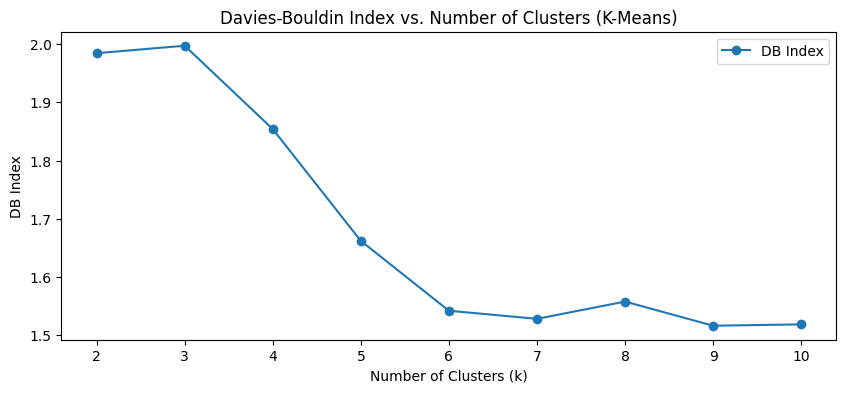

In [27]:
plt.figure(figsize=(10,4))
plt.plot(k_values, db_scores, marker='o', label='DB Index')
plt.title("Davies-Bouldin Index vs. Number of Clusters (K-Means)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("DB Index")
plt.legend()
plt.show()

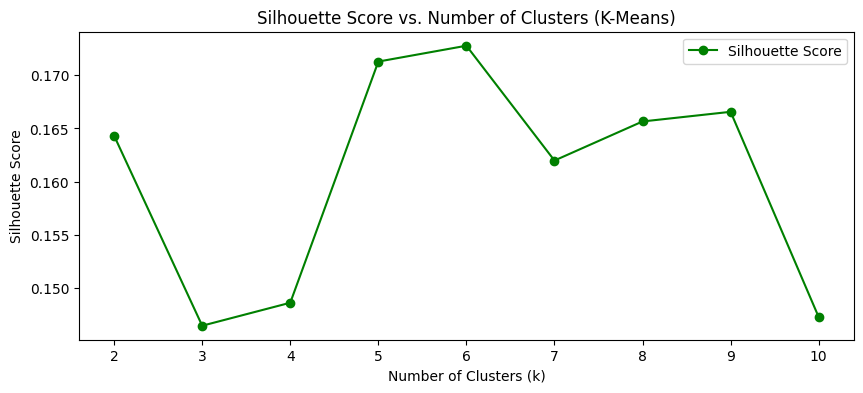

In [28]:
plt.figure(figsize=(10,4))
plt.plot(k_values, sil_scores, marker='o', color='green', label='Silhouette Score')
plt.title("Silhouette Score vs. Number of Clusters (K-Means)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

Picking either 6 or 7 since silhouette score is highest for 6 and 7 has lowest DB index

In [39]:
best_k = 7
best_model = models[best_k]['model']
best_labels = models[best_k]['labels']
best_db_index = models[best_k]['db_index']
best_sil = models[best_k]['silhouette']

In [40]:
print(f"Chosen \n   k={best_k}, \n   DB Index={best_db_index:.4f}, \n   Silhouette={best_sil:.4f}")

Chosen 
   k=7, 
   DB Index=1.5281, 
   Silhouette=0.1620


7. Add Cluster Labels to data and summaries

In [41]:
agg_data['Cluster'] = best_labels
print(agg_data['Cluster'].value_counts())

Cluster
5    38
3    37
1    37
0    30
2    27
6    19
4    11
Name: count, dtype: int64


In [42]:
cluster_summary = agg_data.groupby('Cluster')[feature_cols].mean()
print(cluster_summary)

          TotalSpend    AvgSpend  TxnCount     Recency   SignupYear  \
Cluster                                                               
0        6284.541667  782.267442  8.166667   44.500000  2022.933333   
1        2865.511351  646.534039  4.567568   60.432432  2023.783784   
2        4170.677037  715.240815  6.037037   56.518519  2022.222222   
3        2700.933514  726.626583  3.837838   60.945946  2022.567568   
4        1043.077273  618.568561  1.636364  283.909091  2023.454545   
5        3931.240263  771.601714  5.421053   65.105263  2023.763158   
6        1159.557368  374.572035  3.000000   92.368421  2022.526316   

         SignupMonth    Region  
Cluster                         
0           4.566667  1.366667  
1           2.864865  2.216216  
2           7.259259  2.666667  
3           5.162162  0.567568  
4           5.818182  1.000000  
5           9.973684  1.394737  
6           8.526316  2.052632  


8. Visualize cluster

In [43]:
# we can use pca to reduce the dimensionality of the data to 2D and visualize the clusters
from sklearn.decomposition import PCA

In [44]:
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(X_scaled)

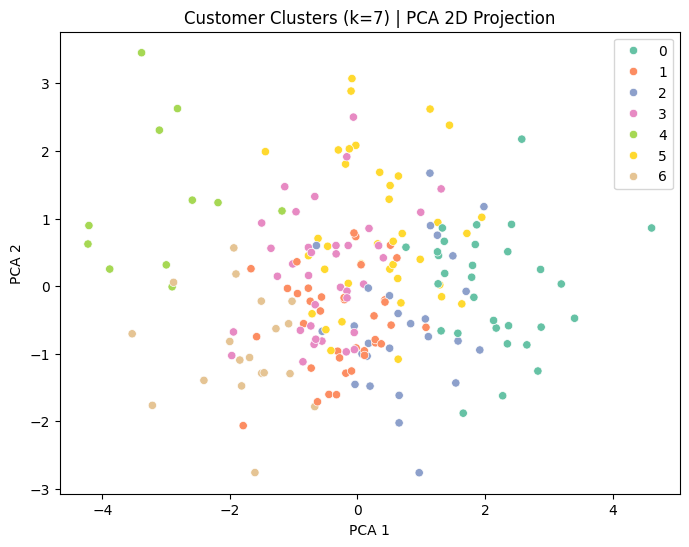

In [45]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_coords[:,0], y=pca_coords[:,1], 
                hue=agg_data['Cluster'], palette='Set2')
plt.title(f"Customer Clusters (k={best_k}) | PCA 2D Projection")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()